In [3]:
%pip install -Uq transformers datasets transformers.utils scikit-learn pandas nltk torch tqdm tensorflow tensorflow.keras matplotlib
%pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.1.0/ru_core_news_sm-3.1.0.tar.gz

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement transformers.utils (from versions: none)
ERROR: No matching distribution found for transformers.utils

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
     --------------------------------------- 0.0/15.9 MB 960.0 kB/s eta 0:00:17
     ---------------------------------------- 0.1/15.9 MB 1.2 MB/s eta 0:00:14
      --------------------------------------- 0.2/15.9 MB 1.7 MB/s eta 0:00:10
      --------------------------------------- 0.4/15.9 MB 2.1 MB/s eta 0:00:08
     - -------------------------------------- 0.6/15.9 MB 2.5 MB/s eta 0:00:07
     -- ------------------------------------- 0.8/15.9 MB 3.0 MB/s eta 0:00:06
     -- ------------------------------------- 0.8/15.9 MB 3.0 MB/s eta 0:00:06
     --- ------------------------------------ 1.2/15.9 MB 3.6 MB/s eta 0:00:05
     --- ------------------------------------ 1.5/15.9 MB 3.6 MB/s eta 0:00:05
     ---- ----------------------------------- 1.9/15.9 MB 4.0 MB/s eta 0:00:04
     ----- ---------------------------------- 2.3/15.9 MB 4.5 MB/s eta 0:00:04
     ------ --------------------------------- 2.5/15.9 MB 


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import re
import numpy as np
import random
from collections import Counter
import warnings
import matplotlib.pyplot as plt
%matplotlib inline 

import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

import torch
from transformers import  BertTokenizer, BertForSequenceClassification 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

nltk.download('stopwords')
warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
num_words = 10000
max_review_len = 100

In [6]:
stemmer = SnowballStemmer('russian')
def stemming(data):
    text = [stemmer.stem(word) for word in data.split()]
    return " ".join(text)

def preprocess_re(text):
    text= text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return filtered_text

def num_of_words(text):
    words = text.split()
    word_count = len(words)
    return word_count

In [7]:

data = pd.read_csv('bank.csv', sep='\t', comment='#')
data["Full_Text"] = data["Text"]

data.head()

,idx,Score,Text,Full_Text
0,0,Positive,В Альфа-Банке работает замечательная девушка -...,В Альфа-Банке работает замечательная девушка -...
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,2,Positive,Очень порадовала оперативность работы в банке....,Очень порадовала оперативность работы в банке....
3,3,Negative,Имела неосторожность оформить потреб. кредит в...,Имела неосторожность оформить потреб. кредит в...
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...,Небольшая предыстория: Нашел на сайте MDM банк...


In [8]:
data['word count'] = data['Text'].apply(num_of_words)
data = data.drop_duplicates('Text')
data.Text = data['Text'].apply(lambda x: stemming(x))
data.Text = data['Text'].apply(preprocess_re)
data.head()

,idx,Score,Text,Full_Text,word count
0,0,Positive,"[альфабанк, работа, замечательн, девушк, ильяс...",В Альфа-Банке работает замечательная девушка -...,110
1,1,Negative,"[оформл, рассрочк, м, виде, мег, тепл, стан, п...",Оформляя рассрочку в м. Видео в меге тёплый ст...,273
2,2,Positive,"[очен, порадова, оперативн, работ, банке, зака...",Очень порадовала оперативность работы в банке....,177
3,3,Negative,"[имел, неосторожн, оформ, потреб, кред, альфаб...",Имела неосторожность оформить потреб. кредит в...,155
4,4,Negative,"[небольш, предыстория, нашел, сайт, mdm, банк,...",Небольшая предыстория: Нашел на сайте MDM банк...,548


In [9]:
data.Score.replace("Positive", 1, inplace=True)
data.Score.replace("Negative", 2, inplace=True)
data.head()

,idx,Score,Text,Full_Text,word count
0,0,1,"[альфабанк, работа, замечательн, девушк, ильяс...",В Альфа-Банке работает замечательная девушка -...,110
1,1,2,"[оформл, рассрочк, м, виде, мег, тепл, стан, п...",Оформляя рассрочку в м. Видео в меге тёплый ст...,273
2,2,1,"[очен, порадова, оперативн, работ, банке, зака...",Очень порадовала оперативность работы в банке....,177
3,3,2,"[имел, неосторожн, оформ, потреб, кред, альфаб...",Имела неосторожность оформить потреб. кредит в...,155
4,4,2,"[небольш, предыстория, нашел, сайт, mdm, банк,...",Небольшая предыстория: Нашел на сайте MDM банк...,548


In [10]:
pos_scores = data[data.Score == 1]


In [11]:
pos_scores["Text"].values

array([list(['альфабанк', 'работа', 'замечательн', 'девушк', 'ильясов', 'орна', 'вежливая', 'отзывчивая', 'действительн', 'участв', 'запрос', 'клиента', 'приход', 'подряд', 'ровн', 'дня', 'кажд', 'ден', 'помн', 'врем', 'мо', 'прихода', 'помогл', 'оформ', 'кред', 'размер', '1млн', 'рублей', 'когд', 'пришл', 'партнер', 'передава', 'е', 'получен', 'кред', 'покупа', 'мно', 'авто', 'специалист', 'ильясов', 'орн', 'помогл', 'нам', 'вывест', 'сумм', 'ден', 'эт', 'непросто', 'сделк', 'состоя', 'оста', 'довольны', 'мо', 'знаком', 'конц', 'всег', 'добавила', 'тепер', 'поняла', 'поч', 'пришл', 'эт', 'отделение', 'эт', 'девушкепобольш', 'замечательн', 'специалистов', 'приобрета', 'программ', 'здоровье', 'вообщ', 'связа', 'альфабанком', 'тепер', 'буд', 'тольк']),
       list(['очен', 'порадова', 'оперативн', 'работ', 'банке', 'заказа', 'интернет', 'карт', 'visa', 'classic', 'потребова', 'подойт', 'банк', 'подписан', 'заявления', 'ден', 'откр', 'текущ', 'счет', 'доступ', 'интернет', 'услуг', 'альфак

In [12]:
count = Counter()
for text in pos_scores['Text'].values:
    for word in text:
        count[word] +=1
count.most_common(15)

[('банк', 18923),
 ('эт', 13745),
 ('карт', 8525),
 ('мо', 7966),
 ('мен', 7609),
 ('очен', 6901),
 ('котор', 5929),
 ('сво', 5094),
 ('отделен', 4977),
 ('сотрудник', 4885),
 ('ещ', 3848),
 ('друг', 3798),
 ('клиент', 3762),
 ('тольк', 3723),
 ('счет', 3699)]

In [13]:
def num_of_words(text):
    words = text.split() if type(text) == str else text
    word_count = len(words)
    return word_count


In [14]:
pos_texts = data[data.Score == 1]
pos_texts.head()

,idx,Score,Text,Full_Text,word count
0,0,1,"[альфабанк, работа, замечательн, девушк, ильяс...",В Альфа-Банке работает замечательная девушка -...,110
2,2,1,"[очен, порадова, оперативн, работ, банке, зака...",Очень порадовала оперативность работы в банке....,177
5,5,1,"[конц, феврал, оформ, кредитн, карт, банк, ава...",В конце февраля оформила кредитную карту банка...,143
10,10,1,"[год, назад, получ, кредитку, выбра, банк, изз...","Год назад получила кредитку, выбрала банк из-з...",201
11,11,1,"[отделен, автозаводск, 01072015, пополня, сво,...",В отделении на Автозаводской 01.07.2015 пополн...,43


In [15]:
count = Counter()
for text in pos_texts['Text'].values:
    for word in text:
        count[word] +=1
count.most_common(15)

[('банк', 18923),
 ('эт', 13745),
 ('карт', 8525),
 ('мо', 7966),
 ('мен', 7609),
 ('очен', 6901),
 ('котор', 5929),
 ('сво', 5094),
 ('отделен', 4977),
 ('сотрудник', 4885),
 ('ещ', 3848),
 ('друг', 3798),
 ('клиент', 3762),
 ('тольк', 3723),
 ('счет', 3699)]

In [16]:
pos_texts = pd.DataFrame(count.most_common(15))
pos_texts.columns = ['word', 'count']
pos_texts.head(15)

,word,count
0,банк,18923
1,эт,13745
2,карт,8525
3,мо,7966
4,мен,7609
5,очен,6901
6,котор,5929
7,сво,5094
8,отделен,4977
9,сотрудник,4885


In [17]:
neg_texts = data[data.Score == 2]
neg_texts.head()

,idx,Score,Text,Full_Text,word count
1,1,2,"[оформл, рассрочк, м, виде, мег, тепл, стан, п...",Оформляя рассрочку в м. Видео в меге тёплый ст...,273
3,3,2,"[имел, неосторожн, оформ, потреб, кред, альфаб...",Имела неосторожность оформить потреб. кредит в...,155
4,4,2,"[небольш, предыстория, нашел, сайт, mdm, банк,...",Небольшая предыстория: Нашел на сайте MDM банк...,548
6,6,2,"[месяц, назад, взял, автокредит, эт, ход, разн...",Месяц назад взял автокредит. До этого ходили п...,387
7,7,2,"[говор, махинац, бонусами, остановл, процент, ...","Не говоря про махинации с бонусами, остановлюс...",119


In [18]:
count = Counter()
for text in neg_texts['Text'].values:
    for word in text:
        count[word] +=1
count.most_common(15)

[('банк', 23105),
 ('эт', 20136),
 ('мо', 13707),
 ('карт', 12196),
 ('мен', 9974),
 ('котор', 8149),
 ('счет', 7355),
 ('сотрудник', 7216),
 ('сво', 5867),
 ('отделен', 5458),
 ('банка', 5426),
 ('ещ', 5355),
 ('дан', 5200),
 ('кредитн', 5043),
 ('ответ', 4876)]

In [19]:
neg_texts = pd.DataFrame(count.most_common(15))
neg_texts.columns = ['word', 'count']
neg_texts.head()

,word,count
0,банк,23105
1,эт,20136
2,мо,13707
3,карт,12196
4,мен,9974


In [20]:
vect = TfidfVectorizer()
X = vect.fit_transform(data["Full_Text"])
Y = data['Score']

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .3)

In [22]:
log_regression = LogisticRegression()
log_regression.fit(x_train, y_train)
log_predict = log_regression.predict(x_test)
log_accuracy = accuracy_score(log_predict, y_test)
print("Accuracy = {:.1%}".format(log_accuracy))

Accuracy = 95.2%


In [23]:
train_d = data.iloc[:12000]
test_d = data.iloc[12000:]

In [24]:
x_train_d = train_d['Text']
y_train_d = train_d['Score'] - 1
texts = x_train_d
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x_train_d = pad_sequences(sequences, maxlen=max_review_len)

In [25]:
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 250)           80250     
                                                                 
 global_max_pooling1d (Glob  (None, 250)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                      

In [26]:
history = model.fit(x_train_d, 
                    y_train_d, 
                    epochs=4,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/4


85/85 [==============================] - 7s 72ms/step - loss: 0.5080 - accuracy: 0.7297 - val_loss: 0.2352 - val_accuracy: 0.9175
Epoch 2/4
85/85 [==============================] - 6s 72ms/step - loss: 0.1619 - accuracy: 0.9431 - val_loss: 0.2109 - val_accuracy: 0.9158
Epoch 3/4
85/85 [==============================] - 6s 71ms/step - loss: 0.0612 - accuracy: 0.9835 - val_loss: 0.2507 - val_accuracy: 0.9133
Epoch 4/4
85/85 [==============================] - 7s 77ms/step - loss: 0.0163 - accuracy: 0.9973 - val_loss: 0.3095 - val_accuracy: 0.9092


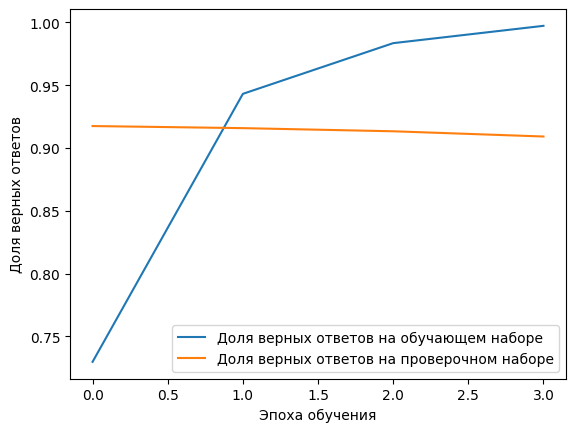

In [27]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [28]:
test_sequences = tokenizer.texts_to_sequences(test_d['Text'])

In [29]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)
y_test = test_d['Score'] - 1

In [30]:
model.evaluate(x_test, y_test, verbose=1)

63/63 [==============================] - 0s 7ms/step - loss: 0.2392 - accuracy: 0.9274


[0.23919011652469635, 0.9274274110794067]

In [31]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [32]:
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
new_sentences = ["Хорошие консультанты и  выгодные предложения мы берем ипотеку.",
                 "Банк плохой консультанты грубили мне я отказываюсь от ипотеки."]
tokens = []
nlp = spacy.load("ru_core_news_sm")
for i in data["Full_Text"]:
    doc = nlp(i)
    token = [token.text for token in doc if not token.is_stop and not token.is_punct]
    tokens.append(token)
data['Text_Tokens'] = tokens



In [34]:
x_train_vectorized = vect.fit_transform(data['Text_Tokens'].apply(lambda x: ' '.join(x)))
new_sentences_vectorized = vect.transform(pd.Series(new_sentences).apply(lambda x: ' '.join(x)))

svm_model = SVC()
svm_model.fit(x_train_vectorized, data['Score'])

predictions = svm_model.predict(new_sentences_vectorized)

for sentence, prediction in zip(new_sentences, predictions):
    if prediction == 1:
        print(f"Предложение: {sentence}\nКлассификация: Positive\n")
    else:
        print(f"Предложение: {sentence}\nКлассификация: Negative\n")


Предложение: Хорошие консультанты и  выгодные предложения мы берем ипотеку.
Классификация: Positive

Предложение: Банк плохой консультанты грубили мне я отказываюсь от ипотеки.
Классификация: Positive



In [35]:
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

new_sentences = ["Это хороший пример.", "Это не очень хороший пример."]

encoded_inputs = tokenizer(new_sentences, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**encoded_inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

label_map = {0: "Negative", 1: "Positive"}
for sentence, prediction in zip(new_sentences, predictions):
    sentiment = label_map[prediction.item()]
    print(f"Предложение: {sentence}\nКлассификация: {sentiment}\n")

x_test = np.array(["Тестовое предложение 1", "Тестовое предложение 2"])  
y_test = np.array([1, 0])  

x_test_encoded = tokenizer(x_test.tolist(), padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**x_test_encoded)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

accuracy = (predictions == torch.tensor(y_test)).sum().item() / len(y_test)
print(f"Точность модели: {accuracy}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Предложение: Это хороший пример.
Классификация: Negative

Предложение: Это не очень хороший пример.
Классификация: Negative

Точность модели: 0.5
